## Propensity Scores

 * [Propensity Scores - Causal Inference Brave and the True](https://matheusfacure.github.io/python-causality-handbook/11-Propensity-Score.html)

In [1]:
import pandas as pd
import numpy as np
import graphviz as gr

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.dpi"] = 100

plt.style.use('default')
sns.set_style("whitegrid")

SEED = 12345
np.random.seed(SEED)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

### Data

In [3]:
data = pd.read_csv("../data/email_obs_data.csv")

In [4]:
Y = "next_mnth_pv"
T = "mkt_email"

X = list(data.drop(columns=[Y, T]).columns)

FORMULA = ' + '.join(X)

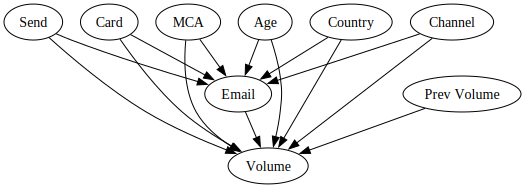

In [5]:
g = gr.Digraph(format="png")

g.edge("Send", "Email")
g.edge("Card", "Email")
g.edge("MCA", "Email")
g.edge("Age", "Email")
g.edge("Country", "Email")
g.edge("Channel", "Email")

g.edge("Email", "Volume")

g.edge("Send", "Volume")
g.edge("Card", "Volume")
g.edge("MCA", "Volume")
g.edge("Age", "Volume")
g.edge("Country", "Volume")
g.edge("Channel", "Volume")
g.edge("Prev Volume", "Volume")

g

In [6]:
(
    data
    .groupby([T])
    .agg({Y: ['mean', 'count']}).round(2)
    .assign(diff=lambda x: x.iloc[1, 0] - x.iloc[0, 0])
)

next_mnth_pv             diff
                  mean   count         
mkt_email                              
0                88.25  146759  1507.97
1              1596.22  153241  1507.97

In [7]:
data[X + [T, Y]].corr()[[T, Y]].head(5)

,mkt_email,next_mnth_pv
age,-0.003991,0.005710
tenure,0.012254,0.007079
amount_spent,0.084948,0.656474
vehicle,0.000391,0.008911
food,0.002199,0.008569


## Propensity Model

 * First we fit a propensity score model to estimate the probability that the user would have been exposed to the treatment $T$ given covariates $X$.
 * The `smf.logit()` is for fitting models where the target variable is a binary integer of either $[0, 1]$ and where the output will be a predicted probability of it being either 0 or 1 based on the features or covariates that we feed into the model.

In [8]:
ps_model = smf.logit(f"{T} ~ {FORMULA}", data=data).fit(disp=0)

In [9]:
data_ps = data.assign(
    propensity_score=ps_model.predict(data),
)

data_ps[[T, Y, "propensity_score"]].head()

,mkt_email,next_mnth_pv,propensity_score
0,0,34.38,0.497203
1,0,183.14,0.518544
2,0,54.26,0.486239
3,1,1409.71,0.501928
4,0,120.16,0.505587


 * Then the first option we can consider is to try good ol' linear regression to estimate the $ATE$, by regressing the treatment and the propensity score on the outcome $Y$ which is purchase value here to give us a simple estimate of what the average treatment effect might be.

In [10]:
model = smf.ols(f"{Y} ~ {T} + propensity_score", data=data_ps).fit()

print(f"ATE: £{model.params[T]:,.2f}")

ATE: £1,313.40


## Raw Propensity Weighting

 * The first method is to just use the raw propensity score weights which can just be defined as the following, where $W$ is the outcome weight and $e(x)$ is the propensity score:

$\Large
W_{\text{raw}} = \left\{\begin{matrix}
e(x) & \text{if  } \;T=1 \\
1-e(x) &  \text{if } \; T=0\\
\end{matrix}\right. 
$

 * Then we take the inverse (i.e. 1 divided by $e(x)$) of the propensity score.
 * Then finally we re-weight the outcome variable by multiplying the inverse of these propensity scores by our outcome (which is `next_month_pv` here).


In [11]:
data_raw = data_ps.assign(
    raw_propensity_score=
        lambda x: np.where(
            x[T] == 1,
            x.propensity_score,
            (1 - x.propensity_score)
        ),
    inverse_propensity_score=lambda x: (1 / x.raw_propensity_score),
    weighted_outcome=lambda x: (x[Y] * x.inverse_propensity_score)
)

In [12]:
N = data_raw.shape[0]

t1 = data_raw.query(f"{T} == 1")
t0 = data_raw.query(f"{T} == 0")

Y1 = t1['weighted_outcome'].sum() / N
Y0 = t0['weighted_outcome'].sum() / N

ate = (Y1 - Y0)

print(f"ATE: £{ate:,.2f}")

ATE: £1,407.60



 * Nice, we get a similar (albeit slightly higher) estimate than the one we got through linear regression.  
 * Or to calculate this more simply you can just do...

In [13]:
ate = np.mean(
    data_ps[Y] * (
        (data_ps[T] - data_ps["propensity_score"])
        / (data_ps["propensity_score"] * (1 - data_ps["propensity_score"]))
    )
)
print(f"ATE: £{ate:,.2f}")

ATE: £1,407.60


## Inverse Propensity Weighting

 * The second (and usually better) option to use is Inverse Propensity Weighting.

 * This version works better when the probability of receiving the treatment is very low, in which case we want to stabilise the propensity score by the probability of receiving the treatment.

 * Also known as the "robust" weighting adjustment, this time we divide the average probability of receiving the treatment by our propensity score.

$\Large
W_{\text{robust}} = \left\{\begin{matrix}
\frac{P(T = 1)}{e(x)} & \text{if  } \;T=1 \\
\frac{1 - P(T = 1)}{1 - e(x)} &  \text{if } \; T=0\\
\end{matrix}\right. 
$

In [14]:
data_ipw = data_ps.assign(
    p_of_t=lambda x: x[T].mean(),
    inverse_propensity_weights=
        lambda x: np.where(
            x[T] == 1,
            (x.p_of_t / x.propensity_score),
            (1 - x.p_of_t) / (1 - x.propensity_score)
        ),
    weighted_outcome=lambda x: (x[Y] * x.inverse_propensity_weights)
)

In [15]:
t1 = data_ipw.query(f"{T} == 1")
t0 = data_ipw.query(f"{T} == 0")

Y1 = t1['weighted_outcome'].sum() / t1.shape[0]
Y0 = t0['weighted_outcome'].sum() / t0.shape[0]

ate = (Y1 - Y0)

print(f"ATE: £{ate:,.2f}")

ATE: £1,407.60


 * **Note:** With raw propensity score weighting it scales both the control + treatment groups to the same size as the entire population of the dataset.
 * This allows us to build a counterfactual world in which **_everyone_** in our dataset either did or did not receive the treatment.

In [16]:
weight_t = 1 / data_ps.query(f"{T} == 1")["propensity_score"]
weight_nt = 1 / (1 - data_ps.query(f"{T} == 0")["propensity_score"])

print(f"Original population size: {data_ps.shape[0]:,.0f}")
print(f"Treated pseudo population size: {np.sum(weight_t):,.0f}")
print(f"Control pseudo population size: {np.sum(weight_nt):,.0f}")

Original sample size: 300,000
Treated pseudo sample size: 300,012
Control pseudo sample size: 297,707


 * By contrast with Inverse Propensity Weighting, you construct the counterfactual treated and control groups which hew far more closely to the original data's sample sizes.

In [17]:
p_of_t = data_ps[T].mean()

t1 = data_ps.query(f"{T} == 1")
t0 = data_ps.query(f"{T} == 0")

weight_t_stable = p_of_t / t1["propensity_score"]
weight_nt_stable = (1 - p_of_t) / (1 - t0["propensity_score"])

print(f"Treat size: {len(t1):,.0f}")
print(f"W treat: {int(np.sum(weight_t_stable)):,.0f}\r\n")

print(f"Control size: {len(t0):,.0f}")
print(f"W treat: {int(np.sum(weight_nt_stable)):,.0f}")

Treat size: 153,241
W treat: 153,246

Control size: 146,759
W treat: 145,637


 * We can also see how reshuffling the data by the constructed weights we've gained gives us a far greater degree of balance between the covariates (or confounders) that we're trying to adjust for in both the treatment and control groups.

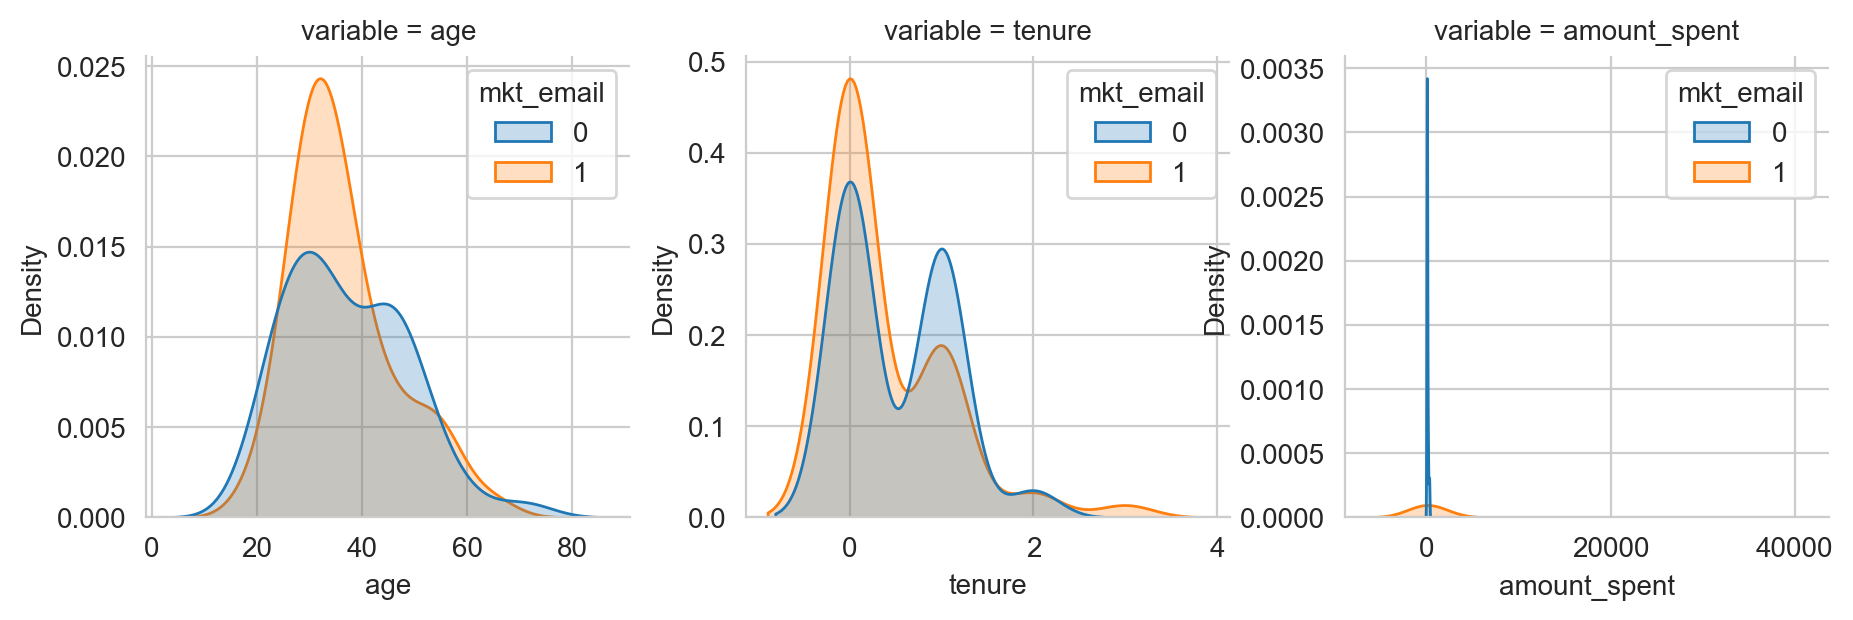

In [18]:
confounders = ['age', 'tenure', 'amount_spent']

plt_df = pd.melt(data[confounders + [T]].sample(100), [T], confounders)

g = sns.FacetGrid(plt_df, col="variable", hue=T, col_wrap=4, sharey=False, sharex=False)

for i, ax in enumerate(g.axes):
    iter_df = plt_df.loc[lambda df: df["variable"] == confounders[i]]
    sns.kdeplot(x="value", hue=T, data=iter_df, ax=ax, fill=True)
    ax.set_xlabel(confounders[i])

plt.show() 

 * Using the stabilised propensity weights we created, we can randomise our observational data based on these weights.

In [19]:
t1 = t1.assign(weight=weight_t_stable)
t0 = t0.assign(weight=weight_nt_stable)

data_rnd = (
    pd.concat([t0, t1])
    .reset_index(drop=True)
    .sample(10_000, replace=True, weights="weight")
)

* Now we have greater balance among each of the confounder subgroups, getting us closer to having two comparable groups, where the only difference is those who received the treatment vs those who did not.

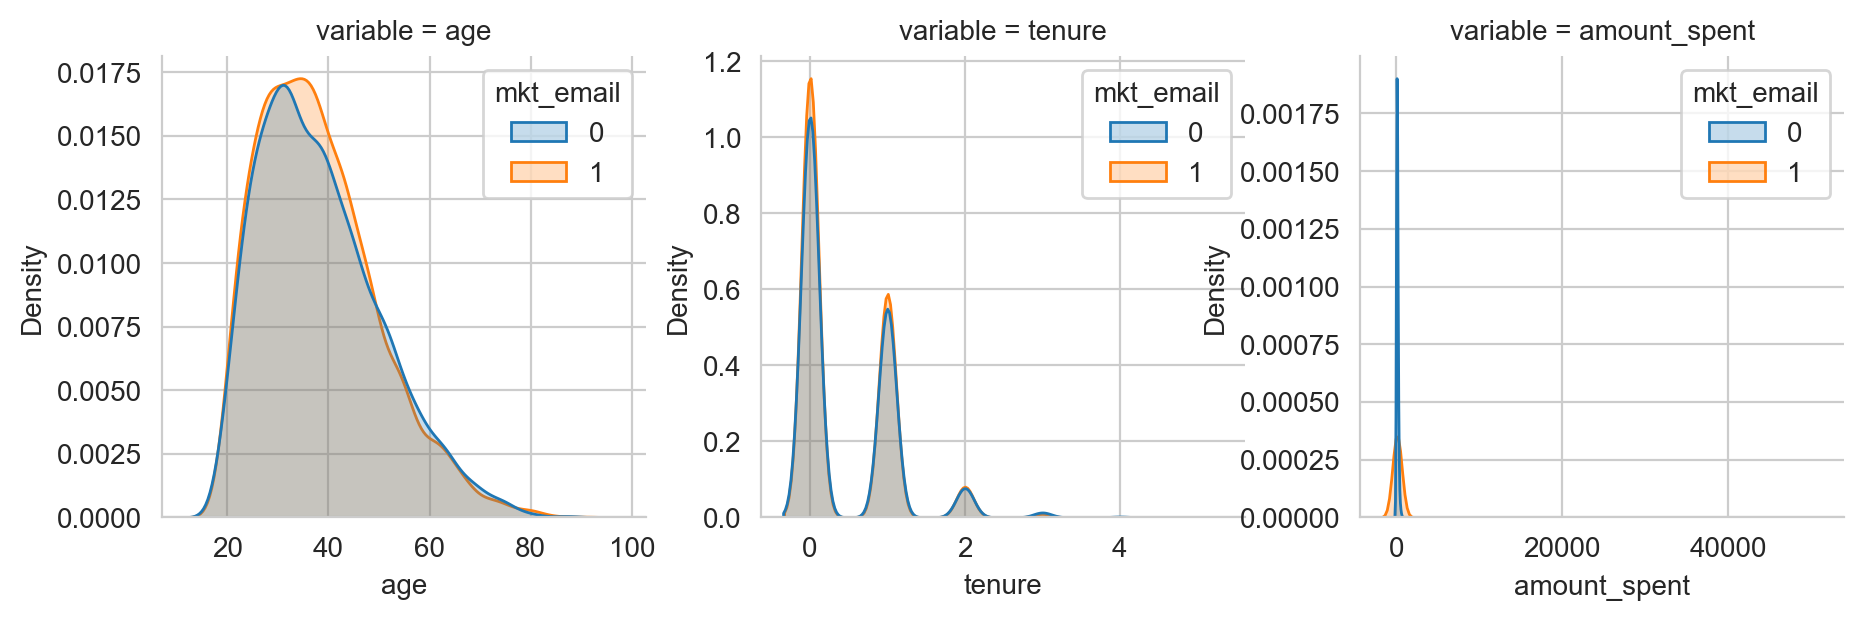

In [20]:
plt_df = pd.melt(data_rnd[confounders + [T]], [T], confounders)

g = sns.FacetGrid(plt_df, col="variable", hue=T, col_wrap=4, sharey=False, sharex=False)

for i, ax in enumerate(g.axes):
    iter_df = plt_df.loc[lambda df: df["variable"] == confounders[i]]
    sns.kdeplot(x="value", hue=T, data=iter_df, ax=ax, fill=True)
    ax.set_xlabel(confounders[i])

plt.show() 

## Doubly Robust Weighting

 * The last option is more of an interesting one (and will become more relevant when we look at implementing ML models for causal inference).

 * The doubly robust estimator combines both IPW based propensity scores, and regular linear regression.

 * By combining the two, it only needs one of the models, **_either_** the propensity score **_or_** the regression (but not necessarily both) to be correctly specified in order to recover the average treatment effect.

> **Frisch-Waugh-Lovell theorem** - The doubly robust estimator is very similar to [FWL theorem](https://matheusfacure.github.io/python-causality-handbook/Debiasing-with-Orthogonalization.html), where we use regression to "debias" the data (i.e. make non-random data look like it's been randomised). First by predicting the probability of receiving the treatment $T$, based on some $X$ variables. Then we fit a separate model to predict the outcome $Y$ using those same set of $X$ variables. And finally we use the errors (or the residuals, i.e. the difference between the predicted and actual ground-truth values) from both models to regress `y_residuals ~ t_residuals` to get an unbiased estimate of the causal effect of $T \rightarrow Y$.

In [21]:
def doubly_robust_adjustment(data: pd.DataFrame, X: list, T: str, Y: str) -> float:

    df = data.copy(deep=True)

    t0 = df.query(f"{T} == 0")
    t1 = df.query(f"{T} == 1")
    
    m0 = sm.OLS(t0[Y], t0[X]).fit()
    m1 = sm.OLS(t1[Y], t1[X]).fit()
    
    m0_hat = m0.predict(df[X])
    m1_hat = m1.predict(df[X])

    Y0 = np.mean((1 - df[T]) * (df[Y] - m0_hat) / (1 - df['propensity_score']) + m0_hat)
    Y1 = np.mean(df[T] * (df[Y] - m1_hat) / df['propensity_score'] + m1_hat)

    ate = (Y1 - Y0)

    return ate

In [22]:
ate = doubly_robust_adjustment(data=data_ps, X=X, T=T, Y=Y)
print(f"ATE: £{ate:,.2f}")

ATE: £1,316.93


In [23]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Oct 13 2024

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.12.3

matplotlib : 3.9.2
numpy      : 1.26.4
seaborn    : 0.13.2
pandas     : 2.2.3
graphviz   : 0.20.3
statsmodels: 0.14.3

Watermark: 2.5.0

